<a href="https://colab.research.google.com/github/geersenthil/Topic-Modeling-/blob/main/NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import required libraries

In [26]:
import pandas as pd
import numpy as np

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

#for histogram
import matplotlib.pyplot as plt
from collections import Counter

#nltk
import nltk 
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords


#import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet


# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#Spacy
import spacy


#Dataset
from sklearn.datasets import fetch_20newsgroups


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load Data into Dataframe

In [27]:
#method that converts data to csv file
def twenty_newsgroup_data_to_csv():
    news_group_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes') ,shuffle=True)

    df = (pd.DataFrame([news_group_data.data, news_group_data.target.tolist()]).T).sample(1500)
    df.columns = ['text', 'target']

    targets = pd.DataFrame( news_group_data.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out.to_csv('20_newsgroup.csv')
twenty_newsgroup_data_to_csv()

In [28]:
#read data from CSV
dataset = pd.read_csv('20_newsgroup.csv', delimiter=',')
dataset.dropna(subset = ["text"], inplace=True)

In [29]:
# Data Size
print("The size of the dataset is: \n", dataset.count())

The size of the dataset is: 
 Unnamed: 0    1469
text          1469
target        1469
title         1469
dtype: int64


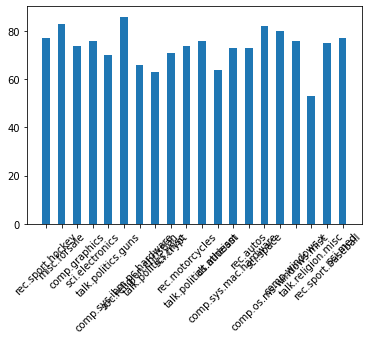

In [30]:
#Category Distribution
counter = Counter(dataset['title'])
topic_names = counter.keys()
topic_counts = counter.values()
ax = plt.gca()
plt.draw()

# Plot histogram using matplotlib bar().
indexes = np.arange(len(topic_names))
width = 0.5
plt.bar(indexes, topic_counts, width)

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.xticks(indexes, topic_names)
plt.show()

In [31]:
print(counter)

Counter({'comp.sys.ibm.pc.hardware': 86, 'misc.forsale': 83, 'sci.space': 82, 'comp.os.ms-windows.misc': 80, 'rec.sport.hockey': 77, 'sci.med': 77, 'sci.electronics': 76, 'talk.politics.mideast': 76, 'comp.windows.x': 76, 'rec.sport.baseball': 75, 'comp.graphics': 74, 'rec.motorcycles': 74, 'comp.sys.mac.hardware': 73, 'rec.autos': 73, 'sci.crypt': 71, 'talk.politics.guns': 70, 'soc.religion.christian': 66, 'alt.atheism': 64, 'talk.politics.misc': 63, 'talk.religion.misc': 53})


## Pre-process the data

Lemmatization to get base words

In [32]:
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADV"]):
  nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
  texts_out = []
  for text in texts:
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)

In [33]:
dataset['news_lemma_text']=lemmatization(dataset['text'])

In [34]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_lemma_text
0,233,\n Here is my traditional experience with ...,10,rec.sport.hockey,here traditional experience ticket playoff oth...
1,1318,\n\n\n\n\nSheesh. The rumor mill strikes agai...,10,rec.sport.hockey,rumor mill strike again let just assume true q...
2,10982,Jesus Christ!!!\n\nThe score is now 6-0. The P...,10,rec.sport.hockey,score now beat shit devil give middle 2nd peri...
3,8138,\n\nTrashy move from a trashy organization. Af...,10,rec.sport.hockey,move trashy organization front office state wo...
4,3041,"UPI Clarinet has just relayed a ""scoop"" from t...",10,rec.sport.hockey,just relay scoop like come agreement next seas...
5,113,\n\nWell I don't see any smileys here. I am t...,10,rec.sport.hockey,see smiley here try figure poster dog wordproc...
6,7195,1st round: \n----------\n\nPITT vs NYI: PITT ...,10,rec.sport.hockey,round look safe bet bag late showdown night ho...
7,6902,only\nappreciated.\n\nPaul Coffey of Detroit R...,10,rec.sport.hockey,only appreciate
8,7307,[more about the Messier-Samuelsson incident]\n...,10,rec.sport.hockey,more incident agree cross check illegal kind c...
9,2892,"\nThey tried their best not to show it, believ...",10,rec.sport.hockey,try good show believe surprised could find spr...


Remove Stopword

In [35]:
stop_words = stopwords.words('english')
print(len(stop_words))
stop_words.extend(['from', 'subject', 're', 'edu', 'use','cdw','would','line','article'])
print(len(stop_words))

179
188


In [36]:
#tokenize
def gen_words(texts):
  final = []

  for text in texts:
    new = gensim.utils.simple_preprocess(text, deacc=True)
    for w in new:
      if w in stop_words or len(w)<3:
        new.remove(w)
    final.append(new)
  return (final)
dataset['news_tokens']=gen_words(dataset['news_lemma_text'])

In [37]:
dataset.head(10)


,Unnamed: 0,text,target,title,news_lemma_text,news_tokens
0,233,\n Here is my traditional experience with ...,10,rec.sport.hockey,here traditional experience ticket playoff oth...,"[traditional, experience, ticket, playoff, oth..."
1,1318,\n\n\n\n\nSheesh. The rumor mill strikes agai...,10,rec.sport.hockey,rumor mill strike again let just assume true q...,"[rumor, mill, strike, let, assume, true, quest..."
2,10982,Jesus Christ!!!\n\nThe score is now 6-0. The P...,10,rec.sport.hockey,score now beat shit devil give middle 2nd peri...,"[score, beat, shit, devil, give, middle, perio..."
3,8138,\n\nTrashy move from a trashy organization. Af...,10,rec.sport.hockey,move trashy organization front office state wo...,"[move, trashy, organization, front, office, st..."
4,3041,"UPI Clarinet has just relayed a ""scoop"" from t...",10,rec.sport.hockey,just relay scoop like come agreement next seas...,"[relay, scoop, like, come, agreement, next, se..."
5,113,\n\nWell I don't see any smileys here. I am t...,10,rec.sport.hockey,see smiley here try figure poster dog wordproc...,"[see, smiley, try, figure, poster, dog, wordpr..."
6,7195,1st round: \n----------\n\nPITT vs NYI: PITT ...,10,rec.sport.hockey,round look safe bet bag late showdown night ho...,"[round, look, safe, bet, bag, late, showdown, ..."
7,6902,only\nappreciated.\n\nPaul Coffey of Detroit R...,10,rec.sport.hockey,only appreciate,[appreciate]
8,7307,[more about the Messier-Samuelsson incident]\n...,10,rec.sport.hockey,more incident agree cross check illegal kind c...,"[incident, agree, cross, check, illegal, kind,..."
9,2892,"\nThey tried their best not to show it, believ...",10,rec.sport.hockey,try good show believe surprised could find spr...,"[try, good, show, believe, surprised, could, f..."


In [38]:
def joinTokens(texts):
  texts_out = []
  for text in texts:
    new_text = []
    for token in text:
            new_text.append(token)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)

In [39]:
dataset['news_joined_text']=joinTokens(dataset['news_tokens'])

In [40]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,news_joined_text
0,233,\n Here is my traditional experience with ...,10,rec.sport.hockey,here traditional experience ticket playoff oth...,"[traditional, experience, ticket, playoff, oth...",traditional experience ticket playoff otherwis...
1,1318,\n\n\n\n\nSheesh. The rumor mill strikes agai...,10,rec.sport.hockey,rumor mill strike again let just assume true q...,"[rumor, mill, strike, let, assume, true, quest...",rumor mill strike let assume true question giv...
2,10982,Jesus Christ!!!\n\nThe score is now 6-0. The P...,10,rec.sport.hockey,score now beat shit devil give middle 2nd peri...,"[score, beat, shit, devil, give, middle, perio...",score beat shit devil give middle period smart...
3,8138,\n\nTrashy move from a trashy organization. Af...,10,rec.sport.hockey,move trashy organization front office state wo...,"[move, trashy, organization, front, office, st...",move trashy organization front office state lo...
4,3041,"UPI Clarinet has just relayed a ""scoop"" from t...",10,rec.sport.hockey,just relay scoop like come agreement next seas...,"[relay, scoop, like, come, agreement, next, se...",relay scoop like come agreement next season in...
5,113,\n\nWell I don't see any smileys here. I am t...,10,rec.sport.hockey,see smiley here try figure poster dog wordproc...,"[see, smiley, try, figure, poster, dog, wordpr...",see smiley try figure poster dog wordprocessor...
6,7195,1st round: \n----------\n\nPITT vs NYI: PITT ...,10,rec.sport.hockey,round look safe bet bag late showdown night ho...,"[round, look, safe, bet, bag, late, showdown, ...",round look safe bet bag late showdown night ho...
7,6902,only\nappreciated.\n\nPaul Coffey of Detroit R...,10,rec.sport.hockey,only appreciate,[appreciate],appreciate
8,7307,[more about the Messier-Samuelsson incident]\n...,10,rec.sport.hockey,more incident agree cross check illegal kind c...,"[incident, agree, cross, check, illegal, kind,...",incident agree cross check illegal kind check ...
9,2892,"\nThey tried their best not to show it, believ...",10,rec.sport.hockey,try good show believe surprised could find spr...,"[try, good, show, believe, surprised, could, f...",try good show believe surprised could find spr...


In [41]:
vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=1000)
X = vectorizer.fit_transform(dataset['news_joined_text'])
words = np.array(vectorizer.get_feature_names())

print(X)
#print("X = ", words)

  (0, 976)	0.11671788337253904
  (0, 607)	0.16380396075291334
  (0, 13)	0.1675629289050506
  (0, 798)	0.19876131025144245
  (0, 519)	0.2049375539540655
  (0, 521)	0.11152966188861843
  (0, 469)	0.15522384831810723
  (0, 262)	0.17975154583186698
  (0, 370)	0.15875397842668287
  (0, 237)	0.1469648984550401
  (0, 486)	0.151536993713378
  (0, 952)	0.1763395895688107
  (0, 306)	0.1825158332714337
  (0, 736)	0.19217829883043114
  (0, 805)	0.16380396075291334
  (0, 654)	0.13370880094552023
  (0, 361)	0.1675629289050506
  (0, 966)	0.17975154583186698
  (0, 291)	0.16889859512446936
  (0, 74)	0.13573424252114324
  (0, 153)	0.12267929398069947
  (0, 217)	0.1825158332714337
  (0, 544)	0.18157305386486763
  (0, 540)	0.17473672478575514
  (0, 369)	0.12533659530563285
  :	:
  (1468, 398)	0.051258028137723614
  (1468, 878)	0.0498969926234223
  (1468, 357)	0.046228948675067556
  (1468, 603)	0.03841514732226083
  (1468, 418)	0.07794081945971255
  (1468, 31)	0.0301690561487367
  (1468, 823)	0.10251605627

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [52]:
# default method in sklearn
from sklearn.decomposition import NMF
 
nmf = NMF(n_components=20, solver="mu")
W = nmf.fit_transform(X)
H = nmf.components_

for i, topic in enumerate(H):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: come,many,much,take,well,thing,time,good,may,make
Topic 2: could,find,reply,info,help,send,appreciate,advance,mail,thank
Topic 3: power,instal,software,meg,cable,price,speed,hard,disk,drive
Topic 4: score,run,good,season,player,year,play,win,team,game
Topic 5: convert,disk,need,format,image,directory,run,window,program,file
Topic 6: bit,board,graphic,monitor,memory,color,mode,video,driver,card
Topic 7: wonder,false,people,way,also,true,believe,talk,read,think
Topic 8: money,could,pay,good,dealer,buy,driver,insurance,price,car
Topic 9: interested,book,condition,original,good,sell,ask,sale,offer,include
Topic 10: armenian,country,crime,government,kill,law,state,gun,right,people
Topic 11: need,pick,net,board,let,year,input,try,picture,get
Topic 12: ground,back,people,week,man,jewish,worth,actually,lot,say
Topic 13: need,help,list,graphic,make,let,happen,want,like,know
Topic 14: see,hear,cross,ask,discussion,like,mail,post,answer,question
Topic 15: hear,least,support,find,code,inf

In [53]:
#Matrix H Article by Word
print(W[:20,:10])

[[7.09741587e-002 0.00000000e+000 6.05066965e-003 1.01182362e-001
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 8.70115448e-009]
 [3.31575257e-002 0.00000000e+000 0.00000000e+000 0.00000000e+000
  5.52628265e-016 1.48320720e-011 3.20761755e-003 1.50803761e-011
  0.00000000e+000 3.01742350e-010]
 [1.53836499e-002 0.00000000e+000 1.51051420e-003 2.85254799e-001
  5.77628941e-013 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 2.00319420e-004]
 [2.68391924e-003 0.00000000e+000 1.20901596e-002 1.58469028e-001
  1.02373169e-002 4.20052270e-003 0.00000000e+000 0.00000000e+000
  0.00000000e+000 4.23875585e-002]
 [2.72890789e-002 0.00000000e+000 3.88280955e-003 7.51183924e-002
  1.38409392e-004 4.54527277e-003 0.00000000e+000 0.00000000e+000
  0.00000000e+000 7.89013209e-012]
 [2.21879502e-002 0.00000000e+000 0.00000000e+000 5.84204338e-009
  0.00000000e+000 0.00000000e+000 0.00000000e+000 1.46521108e-002
  0.00000000e+000 0.00000000e+000

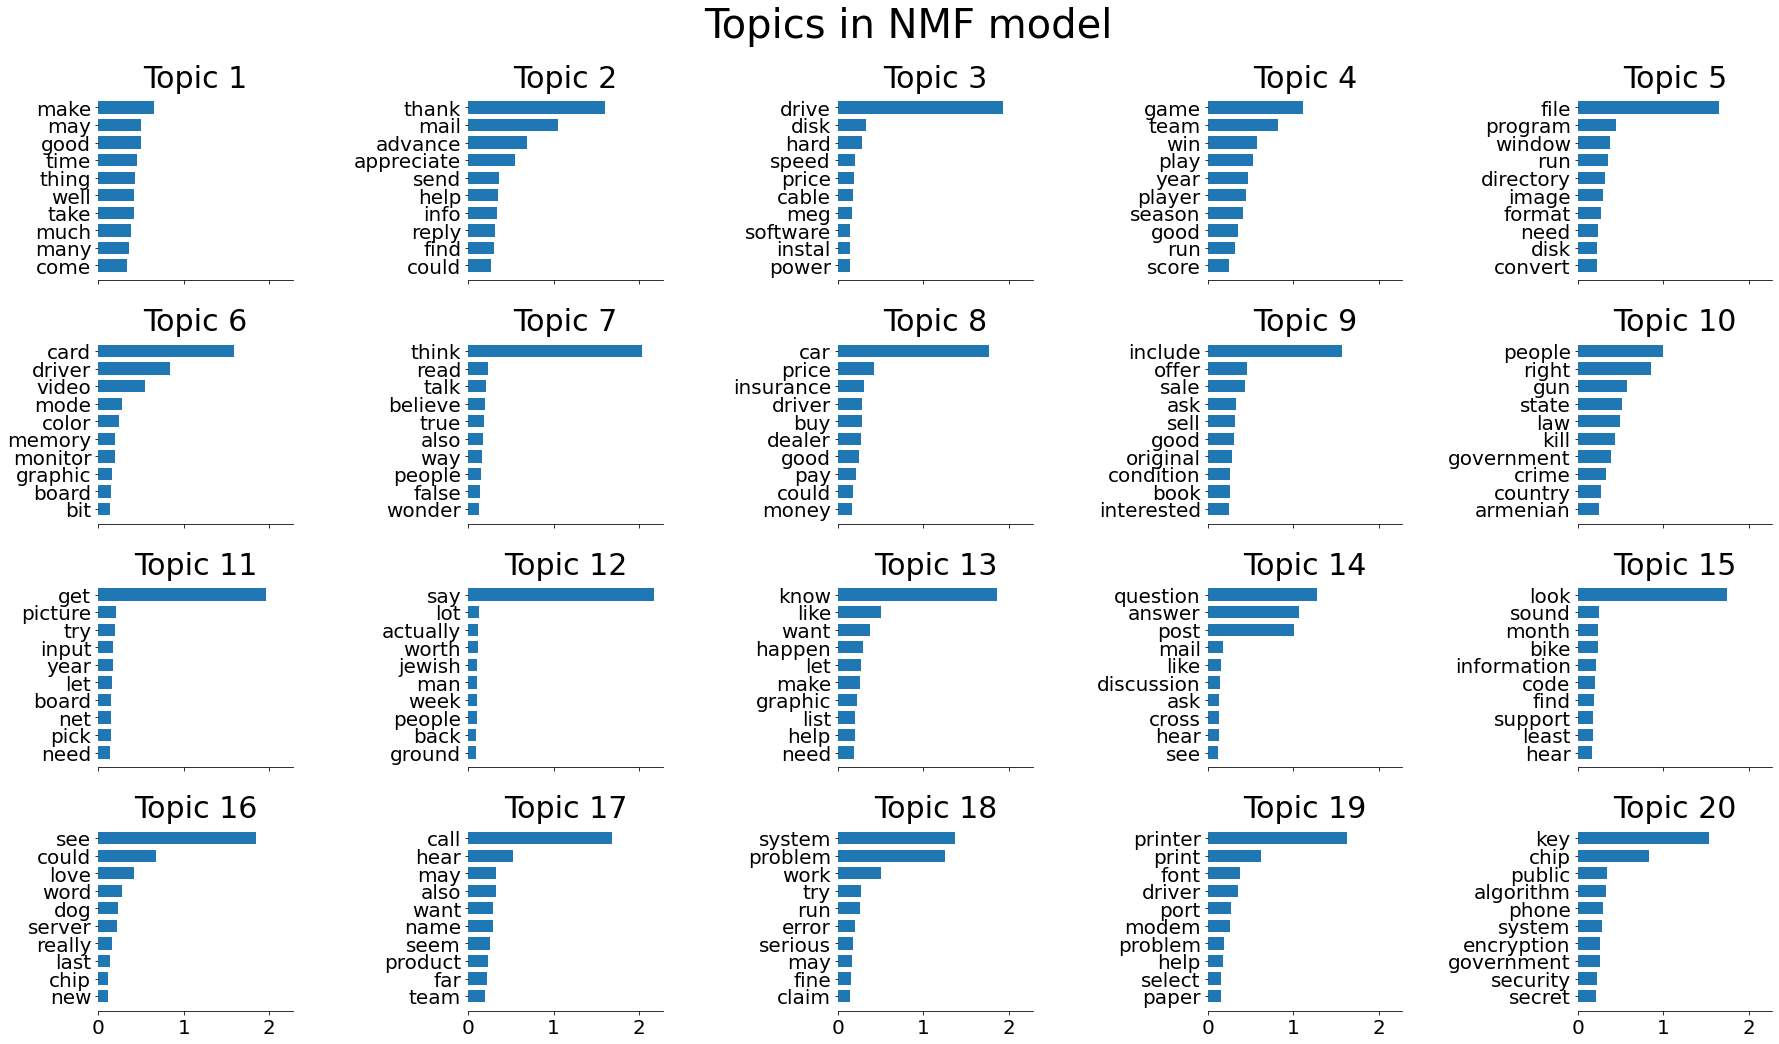

In [54]:
n_components = 20
n_top_words = 10


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()




tfidf_feature_names =vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model")


In [55]:
nmfV = NMF(
    n_components=20,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5,
).fit(X)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


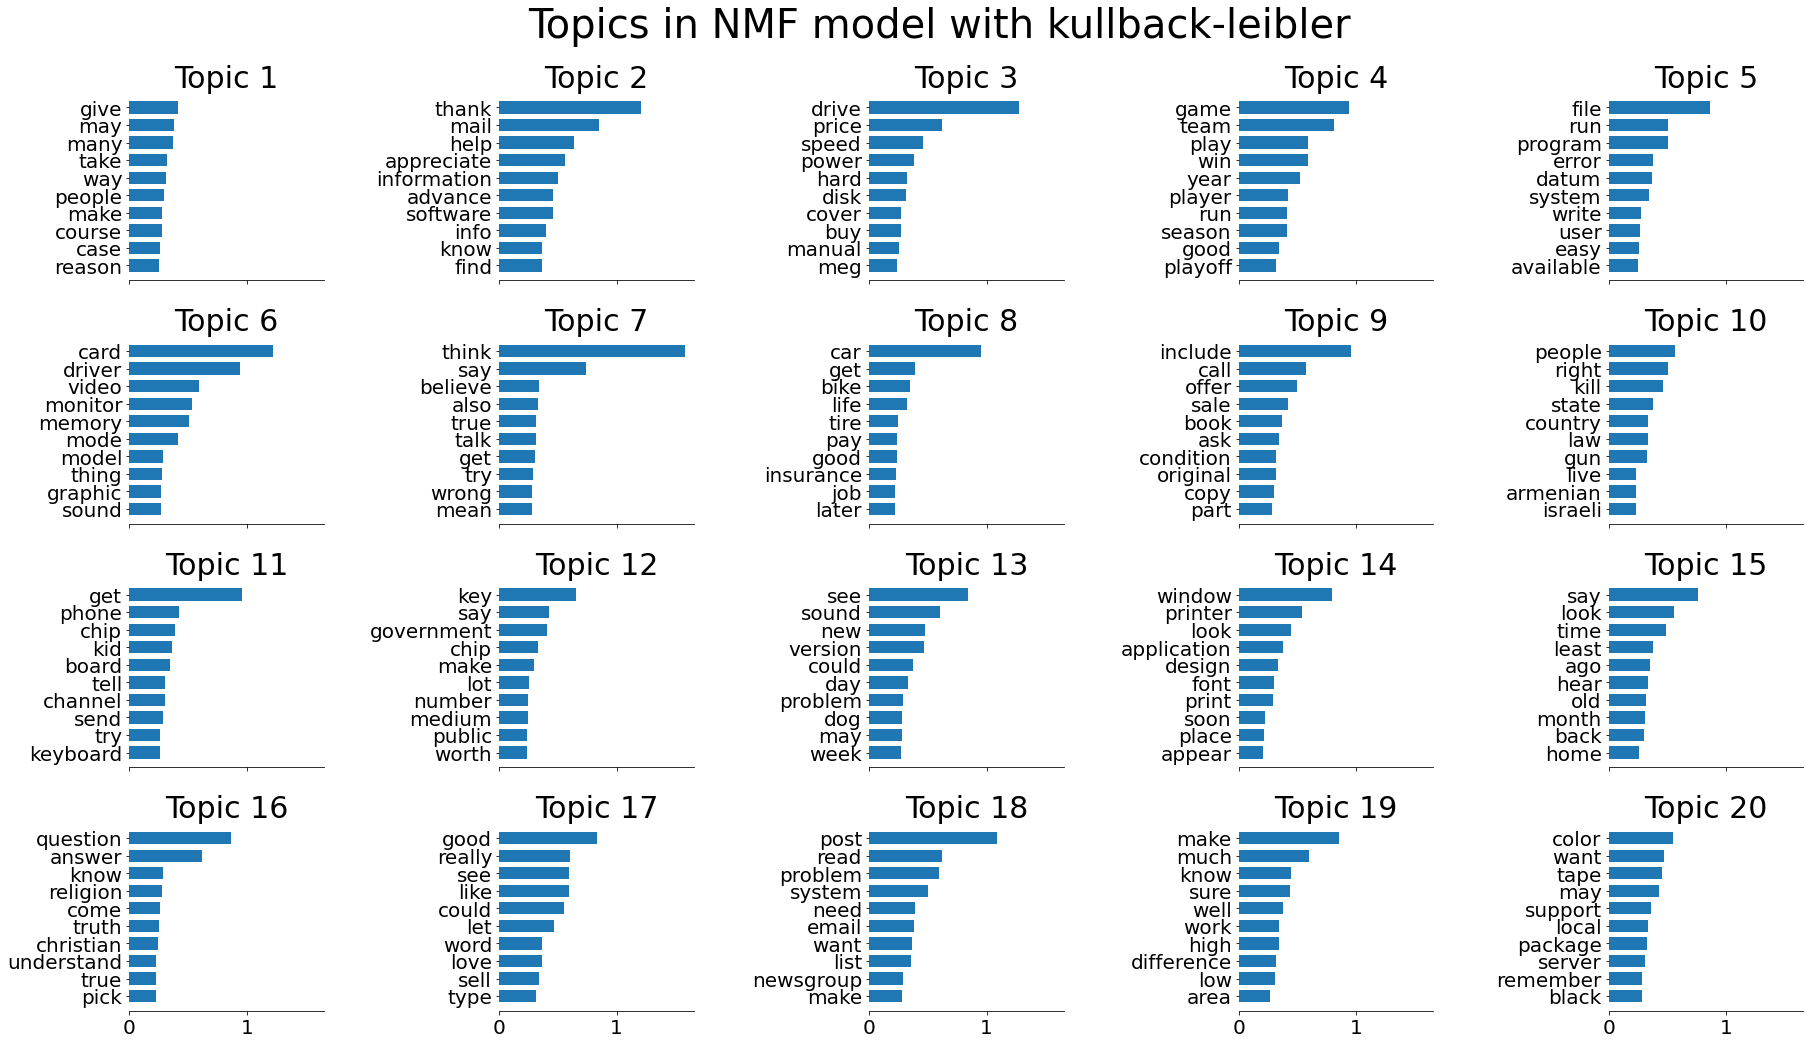

In [56]:
plot_top_words(nmfV, tfidf_feature_names, n_top_words, "Topics in NMF model with kullback-leibler")